In [1]:
import sys
import os
import geopandas as gpd
import pandas as pd

sys.path.append(os.path.abspath(os.path.join(os.pardir)))

from VASA import VASA

/home/alex/.local/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
help(VASA)

Help on class VASA in module VASA.vasa:

class VASA(builtins.object)
 |  VASA(df: 'str or pd.DataFrame', gdf: 'gpd.GeoDataFrame', df_group_col: 'str' = 'fips', gdf_group_col: 'str' = 'fips', date_col: 'str' = 'date', date_format: 'str' = '%Y-%m-%d', temp_res: "Literal[('day', 'week', 'month', 'year')]" = 'week') -> 'None'
 |  
 |  A standard data object for VASA plots
 |  
 |  
 |  Parameters
 |  ----------
 |  
 |  
 |  Attributes
 |  ----------
 |  
 |  
 |  Examples
 |  --------
 |  >>> import libpysal
 |  
 |  Methods defined here:
 |  
 |  __init__(self, df: 'str or pd.DataFrame', gdf: 'gpd.GeoDataFrame', df_group_col: 'str' = 'fips', gdf_group_col: 'str' = 'fips', date_col: 'str' = 'date', date_format: 'str' = '%Y-%m-%d', temp_res: "Literal[('day', 'week', 'month', 'year')]" = 'week') -> 'None'
 |      DOCSTRING
 |  
 |  agg(self, ag)
 |      # I want to change the name of this
 |  
 |  get_county(self, fips: 'int', date='all') -> 'List[int]'
 |      # specify column...
 |  
 |  

In [29]:
mob_data.columns

Index(['fips', 'ds_m4', 'all_day_bing_tiles_visited_relative_change',
       'all_day_ratio_single_tile_users', 'dex', 'num_devices', 'dex_a',
       'num_devices_a', 'state_m2', 'county_m2',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'str_id', 'samples', 'm50',
       'm50_index', 'cases', 'deaths', 'apple_mobility', 'sdi_umd',
       'staying_home_umd', 'miles_per_person_umd', 'non_work_trips_umd',
       'pct_working_home_umd', 'pop', 'delta_cons', 'over60', 'med_income',
       'afram', 'hispar', 'male', 'pop_density', 'empl_density', 'hot_spots',
       'cov_death_rate', 'cci_7days_rolling_avg', 'cmi_7days_rolling_avg',
       'cmi', 'userbase_share', 'cue_devices',
       'sheltered_in_place_7days_rolling

In [2]:

from VASA.vasa import filter_data, filter_map

mob_data = pd.read_csv("../data/all_minor_sources.csv")

# THIS CELL MAY NEED TO BE CHANGED

# Make sure this string matches the column name for the mobility values
# If you have multiple measures in your dataset, it's easiest if you just pick one
columns = [
    'sg_sheltered', "sheltered_in_place_7days_rolling_avg", "sg_avg_dist2", "cmi_7days_rolling_avg"
]

# Make sure this string matches the column name you have for the dates
date_col = "ds_m4"

# Make sure this string matches the column name you have for the county fips
fips_col = "fips"



# This is just used to put text on the plot, it doesn't really make what it says...
titles = [
    '% sheltered (Safegraph)'
]

mob_data = mob_data[["ds_m4", "fips", *columns]]

# Read the map 
usa_map_data = pd.read_json("../data/counties.json")
usa_map = gpd.GeoDataFrame \
    .from_features(usa_map_data["features"]) \
    .set_crs(epsg=4326) \
    .to_crs("+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs")
usa_map = usa_map.assign(fips=[int(g) for g in usa_map["GEOID"]])
usa_map = filter_map(usa_map)

# Group the data into weeks
data = filter_data(mob_data, fips_col)
# grouped_usa = group_data(data, columns, date_col, fips_col, by="week")

In [3]:
data = data.loc[[str(d)[:4] == "2020" for d in data["ds_m4"]]]

In [4]:
from __future__ import annotations
from typing import Literal, Tuple, Callable, List

import numpy as np
import pandas as pd
import geopandas as gpd
import libpysal as lps
from esda import Moran_Local

from functools import partial
# from concurrent import futures
from multiprocessing import cpu_count, Pool
from datetime import datetime as dt

# Commented out for testing...
# from .reduce_vasa_df import *


class VASA:
    """
    A standard data object for VASA plots


    Parameters
    ----------


    Attributes
    ----------


    Examples
    --------
    >>> import libpysal


    """
    def __init__(
        self,
        df: str or pd.DataFrame,
        gdf: gpd.GeoDataFrame,
        df_group_col: str = "fips",
        gdf_group_col: str = "fips",
        date_col: str = "date",
        date_format: str = "%Y-%m-%d",
        temp_res: Literal["day", "week", "month", "year"] = "week"
    ) -> None:
        """
            DOCSTRING
        """
        if isinstance(df, str):
            df = pd.read_csv(df)
        elif not isinstance(df, pd.DataFrame):
            raise Exception("Data not of proper type")

        self.df = df.copy()
        self.df_group_col = df_group_col
        self.gdf = gdf
        self.gdf_group_col = gdf_group_col
        self.date_col = date_col
        self.date_format = date_format
        self.temp_res = temp_res

        self.cols: List[str] = list(
            set(df.columns) - {self.df_group_col, self.date_col}
        )

        # Convert date column to dates
        if isinstance(self.df[self.date_col].dtypes, object):
            self.df[self.date_col] = self.df[self.date_col].apply(
                lambda x: dt.strptime(x, self.date_format).date()
            )
        # NUMPY DATES ??

        # self.group()

    # WE NEED TO CHECK IF THERE IS ONLY ONE GROUP.
    # IF WE ONLY HAVE DATES Jan 1-6, Are these always grouped together?
    def group(self) -> None:
        # pass in functions other than mean
        agg_dict = dict(zip(
            [*self.cols, self.date_col],
            [*np.repeat(np.nanmean, len(self.cols)), "min"]
        ))

        if self.temp_res == "day":
            # assign year_month_day
            grouped = self.df
        elif self.temp_res == "week":
            year_week = [
                get_year_week(date)
                for date in self.df[self.date_col]
            ]

            grouped = self.df \
                .assign(
                    year_week=year_week
                ) \
                .groupby(["year_week", self.df_group_col]) \
                .agg(agg_dict) \
                .reset_index() \
                .groupby(["year_week"])

        elif self.temp_res == "month":
            # assign year_month
            grouped = self.df
        elif self.temp_res == "year":
            # assign year
            grouped = self.df
        else:
            raise Exception("Incorrect temporal resolution")

        # this is going to have to be based on the map or something
        output = pd.DataFrame()
        for _, group in grouped:
            ordered = pd.merge(
                self.gdf, group,
                left_on=self.gdf_group_col, right_on=self.df_group_col,
                how='left'
            )

            output = output.append({
                "date": ordered.loc[0, self.date_col],
                **{c: ordered[c] for c in self.cols}
            }, ignore_index=True)

        self.fips_order = ordered[self.gdf_group_col]
        self.dates = output["date"]
        self.df = output
        # return (output, ordered[self.gdf_group_col])

    # specify column...
    def get_county(self, fips: int, date="all") -> List[int]:
        i = list(self.fips_order).index(fips)
        return [row[self.cols[0]][i] for _, row in self.df.iterrows()]

    # df / list idk, specify columns
    def get_week(self, i: int) -> pd.DataFrame:
        return self.df.loc[i, self.cols[0]]

    def save_output(self, date, fips, vars):
        return 1

    def lisa(self) -> None:
        num_processes = cpu_count()

        W = lps.weights.Queen(self.gdf["geometry"])
        W.transform = 'r'

        with Pool(num_processes) as pool:
            for col in self.cols:

                self.df[col] = list(
                    pool.map(
                        partial(func, col=col,
                                W=W, sig=0.05, which="fdr"),
                        [row for _, row in self.df.iterrows()]
                    )
                )

    def reduce(
        self,
        # this could return anything really...
        reduce: (
            Literal["count", "recency", "count_hh", "count_ll", "mode"] |
            Callable[[List[List[int]]], List[int]]
        )
    ) -> pd.DataFrame:
        copy: pd.DataFrame = self.df[self.cols].copy()

        if reduce == "count":
            reduce = reduce_by_count
        elif reduce == "count_hh":
            reduce = reduce_by_count_hh
        elif reduce == "count_ll":
            reduce = reduce_by_count_ll
        elif reduce == "recency":
            reduce = reduce_by_recency
        elif reduce == "mode_sig":
            reduce = reduce_by_mode_sig
        elif reduce == "mode":
            reduce = reduce_by_mode

        return copy \
            .agg(reduce) \
            .assign(fips=self.fips_order)

    # I want to change the name of this
    def agg(self, ag):
        return 1


def func(ordered, col, W, sig, which):
    return moran_quadrants(ordered[col], W, sig, which=which)

# esda fdr is not strictly doing fdr


def false_discovery_rate(arr, sig):
    df = pd.DataFrame(arr, columns=["p"]).sort_values("p")
    df["i"] = np.arange(1, len(arr) + 1) * sig / len(arr)
    df["sig"] = df["p"] < df["i"]
    return list(df.sort_index()["sig"])


def bonferroni(arr, sig):
    return list(np.array(arr) < sig / len(arr))


# We don't want to filter
def filter_quadrants(arr):
  #  return arr
    return [(a if a < 3 else a) for a in arr]


# this needs to change if we don't filter
def combine(sim, fdr, bon):
    return [
        (b + 4 if b != 0 else (f + 2 if f != 0 else s))
        for b, f, s in zip(bon, fdr, sim)
    ]

#
#
#
#
#

#
# This function runs the local moran test for us and returns an array of
# the quadrant classification for each county
#
#


#
# STILL GET THE ISSUE WHERE VERYTHING IS A 2 
#
def moran_quadrants(col, W, alpha, which):
    local_moran = Moran_Local(col, W, geoda_quads=True,
                              permutations=n_permutations(col))

    ps = local_moran.p_sim
    qs = filter_quadrants(local_moran.q)

    if which == "fdr":
        f = false_discovery_rate(ps, alpha)
    elif which == "sim":
        f = [p < alpha for p in ps]
    elif which == "bon":
        f = bonferroni(ps, alpha)
    elif which == "all":
        fdr = false_discovery_rate(ps, alpha)
        bon = bonferroni(ps, alpha)
        sim = [p < alpha for p in ps]

        qs = combine(
            qs * np.array(sim),
            qs * np.array(fdr),
            qs * np.array(bon)
        )
        f = sim
    else:
        raise 'Valid p-value evaluations: "bon", "fdr", or "sim"'

    return list(qs * np.array(f))


def n_permutations(df):
    return 999  # default value


def get_year_week(date: dt) -> Tuple[int, int]:
    """
    get_year_week [summary]

    Args:
        date (dt): [description]

    Returns:
        Tuple[int, int]: [description]
    """
    week_num = date.isocalendar()[1]
    year = date.year

    if week_num == 1 and date.month == 12:
        year += 1
    elif week_num == 53 and date.month == 1:
        year -= 1

    # Year comes first so dataframe is sorted chronologically
    return (year, week_num)

#
#
#

def _filters(n, coverage="usa", excl_non48=True):
    output = True

    if n == 11001: # DC
        output = False
    if excl_non48 and n >= 2000 and n <= 2999: # exclude AK
        output = False
    if excl_non48 and n >= 15001 and n <= 15009: # exclude HI
        output = False
    if n >= 60010: # territories and such
        output = False
    if n == 53055 or n == 25019: # ISLANDS WITH NO NEIGHBORS
        output = False
    if n == 51515: # Bedford County VA, code was changed in 2013
        output = False

    return output

def filter_data(data, fips_col, coverage="usa", excl_non48=True):
    filters = [
        _filters(x[fips_col], coverage, excl_non48) for _, x in data.iterrows()
    ]
    return data.loc[filters]

def filter_map(data, coverage="usa", excl_non48=True):
    # remove ? - I was doing something different for maps...

    filters = [
        _filters(x["fips"], coverage, excl_non48) for _, x in data.iterrows()
    ]
    return data.loc[filters]



In [5]:
# This is not going to be front facing so it's nice if we have
# general comments but odn't need documentation or doc strings

"""
Utility Reducing Functions for VASA Object
-------------------------------------------------------

Three types:
    * Reducing by count:
        Adding up the total number of times the
        county attained some LISA classification.

    * Reducing by recency:
        The last week number of the time a county
        attained some LISA classification.

    * Reducing by mode:
        The most often LISA classification of a county.
"""

from typing import List, Tuple, Callable
from functools import reduce
import numpy as np
from scipy.stats import mode

HC_List = List[Tuple[int, int]]
County_History_List = List[List[int]]
County_list = List[int]


def reduce_by_count(arr: County_History_List) -> HC_List:

    # Start with pairs of 0 for each county
    initial: HC_List = [(0, 0) for _ in range(len(arr[0]))]

    reducer: Callable[[HC_List, List[int]], HC_List] = lambda acc, curr: [
        (a[0] + (c == 1), a[1] + (c == 2)) for a, c in zip(acc, curr)
    ]

    hh_ll: HC_List = reduce(
        reducer,
        arr,
        initial
    )

    return hh_ll


def reduce_by_count_hh(arr: County_History_List) -> County_list:
    return reduce_by_count_equals(arr, 1)


def reduce_by_count_ll(arr: County_History_List) -> County_list:
    return reduce_by_count_equals(arr, 2)


def reduce_by_count_equals(arr: County_History_List, val: int) -> County_list:
    return reduce(
        lambda acc, curr: np.array(acc) + (np.array(curr) == val),
        arr
    )


# ughhh this needs to be made better
# this should return a date for each classification....
def reduce_by_recency(arr: County_History_List) -> County_list:
    return [
        (hh if clas == 1 else (ll if clas == 2 else 0))
        for hh, ll, clas in zip(
            reduce_by_recency_hh(arr),
            reduce_by_recency_ll(arr),
            reduce_by_mode_sig(arr)
        )
    ]


def reduce_by_recency_hh(arr: County_History_List) -> County_list:
    return reduce_by_recency_equals(arr, 1)


def reduce_by_recency_ll(arr: County_History_List) -> County_list:
    return reduce_by_recency_equals(arr, 2)


def reduce_by_recency_equals(
    arr: County_History_List,
    val: int
) -> County_list:
    return [
        max([
            (idx if week[county_idx] == val else 0)
            for idx, week in enumerate(arr)
        ])
        for county_idx in range(len(arr[0]))
    ]


# not really mode b/c prefers sig over non-sig
# change to list for loop thingy
def reduce_by_mode_sig(arr: County_History_List) -> County_list:
    output: County_list = []

    for hh, ll in reduce_by_count(arr):
        region_class = 1 if hh > ll else 2
        output.append(region_class if max(hh, ll) > 0 else 0)

    return output


def reduce_by_mode(arr: County_History_List) -> County_list:
    return [
        mode([
            week[county_idx]
            for week in arr
        ])[0][0]  # argh
        for county_idx in range(len(arr[0]))
    ]


In [35]:
data.columns

Index(['ds_m4', 'fips', 'sg_sheltered', 'sheltered_in_place_7days_rolling_avg',
       'sheltered_in_place_7days_rolling_avg', 'cmi_7days_rolling_avg'],
      dtype='object')

In [6]:
v = VASA(data, usa_map, date_col="ds_m4")
v.group()
v.lisa()

KeyError: 'date'

In [99]:
for i, row in v.df.iterrows():
    print(row["sheltered_in_place_7days_rolling_avg"][0])

0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0


In [9]:
v.reduce("count")

,sg_avg_dist2,sheltered_in_place_7days_rolling_avg,sg_sheltered,cmi_7days_rolling_avg,fips
0,"(0, 1)","(13, 0)","(36, 0)","(0, 3)",6075
1,"(0, 17)","(22, 1)","(33, 1)","(0, 12)",25025
2,"(0, 1)","(0, 1)","(1, 1)","(0, 3)",31007
3,"(0, 1)","(0, 1)","(0, 1)","(15, 1)",37181
4,"(0, 1)","(0, 36)","(0, 8)","(0, 32)",48421
...,...,...,...,...,...
3100,"(0, 1)","(23, 1)","(15, 1)","(0, 9)",32005
3101,"(0, 1)","(0, 7)","(0, 3)","(1, 1)",29163
3102,"(0, 1)","(0, 3)","(0, 1)","(0, 2)",19079
3103,"(0, 1)","(0, 23)","(0, 7)","(1, 1)",19027


In [10]:
scatterplot(v)

NameError: name 'scatterplot' is not defined

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

# This is not going to be front facing
# // don't need docs/doc string
# but genearl stuff would be nice

# Probably need to double check the typing here
#
# import matplotlib as mpl
# mpl.axes._subplots.AxesSubplot
# mpl.figure.Figure


class BasePlot:

    def __init__(
        self,
        fig: mpl.figure.Figure,
        folder: str
    ) -> None:
        self.fig = fig
        self.folder = folder

        if not os.path.exists(f"{folder}/"):
            os.makedirs(f"{folder}/")

    def save_plot(
        self, name: str,
        file_ext: str = "png",
        dpi: int = 150,
        subfolder: str = "",
        override: bool = False
    ):
        output = f"{self.folder + ('/' if subfolder else '') + subfolder}/"
        if not os.path.exists(f"{output}/"):
            os.makedirs(f"{output}/")

        file_name = f"{output}/{name}.{file_ext}"

        if not override:
            i = 0
            while os.path.isfile(file_name):
                i += 1
                file_name = f"{output}/{name} ({i}).{file_ext}"

        self.fig.set_facecolor("w")
        self.fig.tight_layout()
        self.fig.savefig(
            file_name,
            bbox_inches='tight',
            dpi=dpi
        )

    def hide_axis(self, ax: plt.Axes):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
from typing import List

#from VASA.preprocessing.vasa import VASA
#from VASA.BasePlot import BasePlot


class Scatter(BasePlot):

    def __init__(self, v: VASA, cols=None):
        fig, axes = plt.subplots(
            math.ceil(len(v.cols) / 2),
            min(len(v.cols), 2),
            figsize=(8, 8)
        )
        super().__init__("scatter", "scatter_test")

        self.v: VASA = v
        self.fig = fig
        self.axes = [axes] if len(v.cols) == 1 else axes.flatten()
        self.plotted = False

    # plot args for like colors??
    # showLines: bool or List[int] # fips
    def plot(self, titles: str or List[str] = ""):
        count = self.v.reduce("count")
        recent = self.v.reduce('recency')

        df = count.merge(
            recent,
            left_on="fips",
            right_on="fips",
            how="inner",
            suffixes=("_count", "_recency")
        ).reset_index()

        # df["count"] = [
        #     max(c)
        #     for c in df["sheltered_in_place_7days_rolling_avg_count"]
        # ]
        # df["which"] = [
        #     (1 if h > c else 0)
        #     for h, c in df["sheltered_in_place_7days_rolling_avg_count"]
        # ]

        # df = df.rename(
        #     { "sheltered_in_place_7days_rolling_avg_recency": "recent" },
        #     axis="columns"
        # )

        # print(df)

        # points = df.groupby(["count", "recent"]).agg(np.mean)

        print(self.axes)

        for i, ax in enumerate(self.axes):
            col: str = self.v.cols[i]

            # print(col, df.columns)

            points = df[[f"{col}_count", f"{col}_recency"]]
            points["count"] = [
                max(c)
                for c in points[f"{col}_count"]
            ]
            points["which"] = [
                (1 if h > c else 0)
                for h, c in points[f"{col}_count"]
            ]
            points = points.rename(
                {f"{col}_recency": "recent"},
                axis="columns"
            )
            points = points.groupby(["count", "recent"]).agg(np.mean)

            print(points.head())

            self.__create_scatter(ax, points)

        self.plotted = True
        return self.fig

    def __create_scatter(self, ax, df: pd.DataFrame):
        sns.scatterplot(
            x="recent",
            y="count",
            data=df,
            hue="which",
            palette="bwr",
            ax=ax
        )

    def save_plot(self, *args, **kwargs):
        if not self.plotted:
            return

        super().save_plot(*args, **kwargs)

    # def create_scatter(ax, df):
    #     #ax.scatter(xs, ys, c="blue", alpha=0.3)
    #     sns.scatterplot(x="recent", y="count", data=df, hue="which", palette="bwr", ax=ax)
    #     # slope = 1 line
    #     # ax.plot(range(0, max(xs) + 1), range(0, max(xs) + 1))


    # def create_scatter(ax, df):
    #     #ax.scatter(xs, ys, c="blue", alpha=0.3)
    #     sns.scatterplot(x="recent", y="count", data=df, hue="which", palette="icefire", ax=ax)
    #     # slope = 1 line
    #     # ax.plot(range(0, max(xs) + 1), range(0, max(xs) + 1))


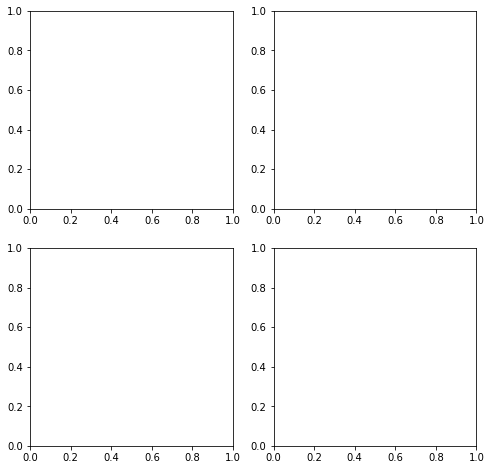

In [13]:
scatplt = Scatter(v)

[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
              which
count recent       
0     0         0.0
1     11        1.0
      22        0.0
      47        0.0
      51        0.5
              which
count recent       
0     0         0.0
1     42        1.0
      52        0.0
2     3         1.0
      4         1.0
              which
count recent       
0     0         0.0
1     1         0.0
      2         1.0
      11        0.0
      35        0.0
              which
count recent       
0     0         0.0
1     0         0.0
      3         0.0
      33        0.0
      37        0.0
<ipython-input-12-3386f2918cf5>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points["count"] = [
<ipython-input-12-3386f2918cf5>:

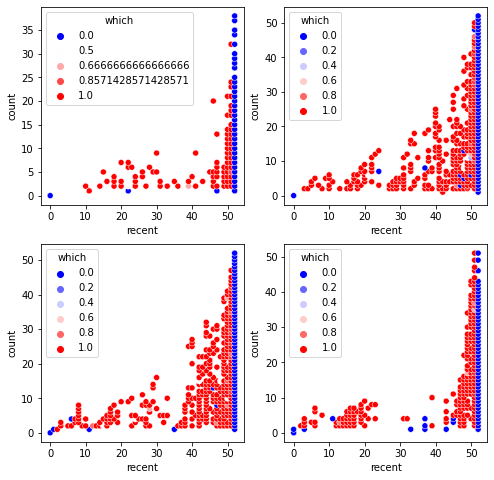

In [14]:
scatplt.plot()

In [15]:
scatplt.save_plot("test1")

In [13]:

# add state names
state_names = pd.read_html('https://en.wikipedia.org/wiki/Federal_Information_Processing_Standard_state_code')
print(len(state_names))

state_names = state_names[0]

state_names.columns = ['name', 'letter_abbr', 'num_code', 'stat']

state_names.drop('stat', axis=1, inplace=True)

state_names.num_code = state_names.num_code.apply(lambda x: '0' + str(x) if len(str(x))==1 else str(x))

state_names.head()

state_names.loc[state_names.num_code=='25']

5


,name,letter_abbr,num_code
33,Massachusetts,MA,25


In [25]:
# # add state names
# state_names = pd.read_html('https://en.wikipedia.org/wiki/Federal_Information_Processing_Standard_state_code')
# print(len(state_names))

# state_names = state_names[0]

# state_names.columns = ['name', 'letter_abbr', 'num_code', 'stat']

# state_names.drop('stat', axis=1, inplace=True)

# state_names.num_code = state_names.num_code.apply(lambda x: '0' + str(x) if len(str(x))==1 else str(x))

# state_names.head()

# state_names.loc[state_names.num_code=='25']

import matplotlib.pyplot as plt

from VASA.vasa import VASA
from VASA.BasePlot import BasePlot


class Strip(BasePlot):

    def __init__(self, v: VASA, cols=None):
        # fig, axes = plt.subplots(
        #     1,
        #     1,
        #     figsize=(8, 8)
        # )
        super().__init__("scatter", "striptest")

        #self.fig = fig
        #self.axes = [axes]
        self.v: VASA = v

    def plot(self):
        ndf = self.v.reduce("mode")
        ndf['state_num'] = [
            str(f // 1000) for f in ndf.fips
        ]  # .str.slice(start=0, stop=2)
        ndf['state_num'] = [
            ("0" + str(f//1000) if f//1000 < 10 else str(f//1000))
            for f in ndf.fips
        ]
        ndf = pd.merge(
            ndf,
            state_names,
            how='left',
            left_on='state_num',
            right_on='num_code'
        )

        counties_per_state = ndf.groupby(['fips','letter_abbr']) \
            .size() \
            .reset_index() \
            .rename(columns={0:'count'}) \
            .groupby('letter_abbr')['fips'] \
            .size() \
            .reset_index()

        check1 = usa_map \
            .groupby('STATEFP') \
            .size() \
            .reset_index() \
            .set_index("STATEFP") \
            .sort_index()

        check2 = ndf.groupby(['fips','num_code']) \
            .size() \
            .reset_index() \
            .rename(columns={0:'count'}) \
            .groupby('num_code')['fips'] \
            .size() \
            .reset_index() \
            .set_index('num_code') \
            .sort_index()

        #gdf.head()

        check1.columns = ['cnt']

        # print(counties_per_state)

        moder = ndf.loc[ndf[v.cols].sum(axis=1)>0,]
        lst_row = []

        for i in self.v.cols:
            g = moder[['letter_abbr', i]].groupby(['letter_abbr', i]).size().reset_index()
            g['source'] = i
            g.columns = ['letter_abbr', 'val', 'count', 'source']
            lst_row.append(g)

        cc = pd.concat(lst_row) 
        cc = cc.loc[cc.val!=0,]

        print("---- CC.head() ----")
        print(cc.groupby(["source", "val"]).size())

        print(cc.head())
        print(cc.shape)

        ppiv = cc.pivot(index=['letter_abbr', 'val'], columns='source', values='count')
        ppiv = ppiv.reset_index()

        print("--- ppiv.head() ---")
        print(ppiv.head())

        ppiv = ppiv[['letter_abbr', 'val', *self.v.cols]]


        msc = pd.merge(check1, state_names, left_on='STATEFP', right_on='num_code')
        ppiv = pd.merge(ppiv, msc, how='left', on='letter_abbr')

        last_idx = 2 + len(self.v.cols)

        ppiv.iloc[:, 2:last_idx] = ppiv.iloc[:, 2:last_idx].div(
            ppiv.cnt, axis=0
        ) * 100

        ppiv.iloc[:, 2:last_idx] = ppiv.iloc[:, 2:last_idx].apply(
            lambda x: round(x, 1)
        )

        #
        #
        #   PLOT
        #
        #

        sns.set_theme(style="whitegrid")
        #open_circle = mpl.path.Path(vert)

        text_style = dict(
            horizontalalignment='right',
            verticalalignment='center',
            fontsize=12,
            fontfamily='monospace'
        )

        print("--ppiv 2222222222 ---")
        print(ppiv.head())

        # Make the PairGrid
        g = sns.PairGrid(
            ppiv,
            x_vars=ppiv.columns[2:last_idx],
            y_vars=["letter_abbr"],
            hue='val',
            height=10,
            aspect=.25,
            palette=['red', 'blue']
        )

        print("HERE")

        # Draw a dot plot using the stripplot function
        g.map(
            sns.stripplot,
            size=10,
            orient="h",
            jitter=False,
            alpha=.65,
            linewidth=1
        )  # marker=r"$\circ$")#, alpha=0.5)

        print("DONE MAPPING")

        # Use the same x axis limits on all columns and add better labels
        g.set(xlim=(-5, 105), xlabel="", ylabel="")

        # Use semantically meaningful titles for the columns
        titles = ['SafeGraph \nmedian distance traveled', "2", "3", "4"]

        for ax, title in zip(g.axes.flat, titles):

            # Set a different title for each axes
            ax.set(title=title)

            # Make the grid horizontal instead of vertical
            ax.xaxis.grid(False)
            ax.yaxis.grid(True)

        sns.despine(left=True, bottom=True)

        fig = plt.gcf()
        self.fig = fig

        fig.text(
            0.5,
            0.02,
            '% of counties classified as hotspot / coldspot',
            ha='center'
        )

        # fig.savefig('/strip_plot_v2.jpeg', dpi=150, bbox_inches='tight')

    def save_plot(self, *args, **kwargs):
        #if not self.plotted:
        #    return

        super().save_plot(*args, **kwargs)


In [26]:
strp = Strip(v)

---- CC.head() ----
source                                val
cmi_7days_rolling_avg                 1      15
                                      2      20
                                      3       2
                                      4       2
sg_avg_dist2                          1       1
                                      2       9
                                      3       1
sg_sheltered                          1      23
                                      2      16
                                      3       1
                                      4       4
sheltered_in_place_7days_rolling_avg  1      23
                                      2      18
                                      4       1
dtype: int64
   letter_abbr  val  count        source
4           CA    2      2  sg_avg_dist2
7           CT    2      2  sg_avg_dist2
11          GA    3      1  sg_avg_dist2
15          IL    2      1  sg_avg_dist2
21          MA    2      1  sg_avg_dist2
(136, 4

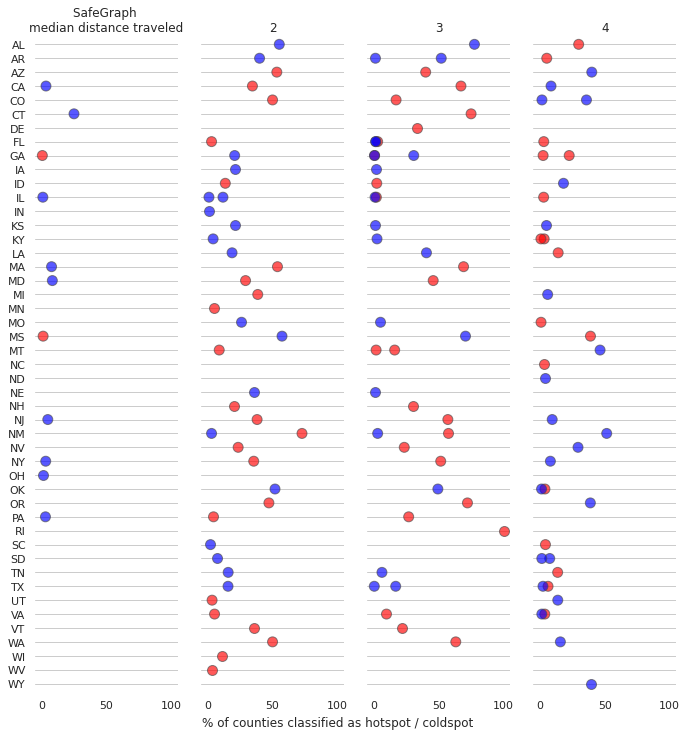

In [27]:
strp.plot()

In [28]:
strp.save_plot("strpplot_test")

<Figure size 432x288 with 0 Axes>

In [186]:

def summary(v):
    df = v.reduce("mode")

    print(df)

In [187]:
summary(v)

      sheltered_in_place_7days_rolling_avg   fips
0                                        0   6075
1                                        0  25025
2                                        0  31007
3                                        0  37181
4                                        2  48421
...                                    ...    ...
3100                                     0  32005
3101                                     0  29163
3102                                     0  19079
3103                                     0  19027
3104                                     0  13073

[3105 rows x 2 columns]


In [11]:
import matplotlib.pyplot as plt

from VASA.vasa import VASA
from VASA.BasePlot import BasePlot


class Summary(BasePlot):

    def __init__(self, v: VASA, cols=None):
        fig, axes = plt.subplots(
            1,
            1,
            figsize=(8, 8)
        )
        super().__init__("scatter_test", "summary")

        self.fig = fig
        self.axes = [axes]
        self.v: VASA = v

    def plot(self):
        ndf = self.v.reduce("mode")
        ndf['state_num'] = [
            str(f // 1000) for f in ndf.fips
        ]  # .str.slice(start=0, stop=2)
        ndf['state_num'] = [
            ("0" + str(f//1000) if f//1000 < 10 else str(f//1000))
            for f in ndf.fips
        ]
        ndf = pd.merge(
            ndf,
            state_names,
            how='left',
            left_on='state_num',
            right_on='num_code'
        )

        ndf = ndf[ndf["state_num"] == "06"]["sg_sheltered"]

        print(self.v.dates)

        dat = pd.concat(
            [self.v.dates.reset_index(drop=True), ndf.reset_index(drop=True)],
            axis=1
        )
        print(dat)


In [12]:
s = Summary(v)
s.plot()

TypeError: object of type 'numpy.float64' has no len()